In [ ]:
import gdown
import os
import zipfile
import pandas as pd
import cv2
from tqdm.autonotebook import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from PIL import Image
from torchvision.transforms import InterpolationMode 
import shutil
import matplotlib.pyplot as plt #
%matplotlib inline
from IPython.display import clear_output
from sklearn.metrics import f1_score
import random
from sklearn.metrics import classification_report

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [ ]:
GLOBAL_RANDOM_STATE=42
random.seed(GLOBAL_RANDOM_STATE)
torch.manual_seed(GLOBAL_RANDOM_STATE)
np.random.seed(GLOBAL_RANDOM_STATE)

Загружаем и распаковываем

In [ ]:
link = 'https://drive.google.com/uc?id=12sWcquYlvGL3oLLtweqv4VVyfYI-9u4U&export=download&confirm=t'

In [ ]:
file = 'journey-springfield.zip'
if not os.path.exists(file):
  gdown.download(link, file, quiet=False)

In [ ]:
with zipfile.ZipFile(file, 'r') as zip:
  zip.extractall(".") 

In [ ]:
train_dir = 'train/simpsons_dataset'

Посмотрим на основные параметры изображений и выполним ручную маркировку категорий 

In [ ]:
def files_stats(dir):
  stats = pd.DataFrame(columns=['character', 'label', 'image', 'h', 'w', 'h:w'])
  labels = {}
  for folder in os.listdir(dir):
    if not folder in labels:
      labels[folder] = len(labels)
    path = dir + os.path.sep + folder + os.path.sep
    for file in os.listdir(path):
      im = Image.open(path + file)
      stats.loc[len(stats)] = [
          folder, 
          labels[folder],
          path + file, 
          im.size[1], 
          im.size[0], 
          im.size[1]/im.size[0],
      ]
      del im
  return stats, labels


In [ ]:
original_stats, original_labels = files_stats(train_dir)

In [ ]:
original_agg_stats = original_stats[['character', 'label', 'h', 'w', 'h:w']]\
  .groupby(['character', 'label']).agg(
    max_h=('h', 'max'), 
    min_h=('h', 'min'), 
    max_w=('w', 'max'), 
    min_w=('w', 'min'),
    avg_w=('w', 'mean'),
    avg_h=('h', 'mean'),
    avg_hw=('h:w', 'mean'), 
    count=('label','count'))\
  .sort_values(by='count')
original_agg_stats

,,max_h,min_h,max_w,min_w,avg_w,avg_h,avg_hw,count
character,label,,,,,,,,
lionel_hutz,37,400,400,528,528,528.000000,400.000000,0.757576,3
disco_stu,21,464,379,576,256,394.000000,425.375000,1.206382,8
troy_mcclure,4,480,416,640,576,616.000000,458.000000,0.743056,8
miss_hoover,39,480,416,640,288,427.294118,445.176471,1.171569,17
fat_tony,5,480,352,640,272,460.444444,436.740741,1.072719,27
gil,26,480,352,640,264,379.555556,409.481481,1.207934,27
otto_mann,10,480,352,640,288,516.250000,432.000000,0.921942,32
sideshow_mel,24,480,352,640,272,497.200000,438.400000,0.972463,40
agnes_skinner,8,480,352,640,256,412.380952,423.142857,1.152240,42


In [ ]:
original_agg_stats.describe()

,max_h,min_h,max_w,min_w,avg_w,avg_h,avg_hw,count
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,547.904762,320.166667,701.357143,276.380952,426.171240,420.118357,1.104521,498.404762
std,151.393496,54.839863,209.880549,63.564430,52.980724,16.290674,0.115693,577.169420
min,400.000000,256.000000,528.000000,256.000000,323.333333,383.341357,0.743056,3.000000
25%,480.000000,256.000000,640.000000,256.000000,394.061977,408.827628,1.051103,49.000000
50%,480.000000,352.000000,640.000000,256.000000,413.578405,422.231597,1.124573,154.500000
75%,524.500000,352.000000,720.000000,272.000000,460.278788,431.240104,1.176755,967.750000
max,1072.000000,416.000000,1912.000000,576.000000,616.000000,458.000000,1.331250,2246.000000


Сильная разбалансированность, которая не даст нормально обобщить классы с малым количеством изображений

Аугментируем, доведя до приемлемого уровня дисбаланса (при этом, не уводя время аугментации и последующего обучения за пределы разумных значений)

In [ ]:
def image_random_transform(image_file, index, target_dir):
  image = Image.open(image_file)
  w, h = image.size
  transforms = {
      TF.rotate: {'angle': random.randint(-30, 30)},
      TF.posterize: {'bits': random.randint(2, 5)},
      TF.hflip: {},
      TF.vflip: {},
      TF.autocontrast: {},
      TF.crop: {
        'top': random.randint(int(0.05 * h), int(0.15 * h)),
        'left': random.randint(int(0.05 * w), int(0.15 * w)),
        'height': random.randint(int(0.75 *h), int(0.85*h)),
        'width': random.randint(int(0.75 *w), int(0.85*w)),  
      },
  }
  for transform in random.sample(transforms.keys(), random.randint(4, len(transforms))):
    kwargs = transforms[transform].copy()
    kwargs.update({'img': image})
    image = transform(**kwargs)
    if random.randint(0, 100) < 5:
      image = TF.to_grayscale(image, num_output_channels=3)
    if random.randint(0, 100) < 5:
      image = TF.invert(image)


  filename, extension = os.path.splitext(os.path.basename(image_file))
  image.save("{0}/{1}-{2}{3}".format(target_dir, filename, index, extension))


def augment(dir, target_dir, target_size):
  if os.path.exists(target_dir):
    shutil.rmtree(target_dir)
  shutil.copytree(dir, target_dir)
  for folder in os.listdir(target_dir):
    path = target_dir + os.path.sep + folder + os.path.sep 
    files = os.listdir(path)
    counter = len(files)
    increment = 0 if len(files) - target_size > 0 else  target_size - len(files)
    print("augmenting {}, {} files".format(folder, increment))
    while counter < target_size:
      for file in files:
        image_random_transform(path + file, counter, path)
        counter += 1



In [ ]:
augmented_train_dir = 'train/simpsons_dataset_augmented'
augment(train_dir, augmented_train_dir, 400)

augmenting barney_gumble, 294 files
augmenting abraham_grampa_simpson, 0 files
augmenting marge_simpson, 0 files
augmenting moe_szyslak, 0 files
augmenting troy_mcclure, 392 files
augmenting fat_tony, 373 files
augmenting lisa_simpson, 0 files
augmenting rainier_wolfcastle, 355 files
augmenting agnes_skinner, 358 files
augmenting nelson_muntz, 42 files
augmenting otto_mann, 368 files
augmenting milhouse_van_houten, 0 files
augmenting martin_prince, 329 files
augmenting snake_jailbird, 345 files
augmenting bart_simpson, 0 files
augmenting professor_john_frink, 335 files
augmenting lenny_leonard, 90 files
augmenting mayor_quimby, 154 files
augmenting ralph_wiggum, 311 files
augmenting kent_brockman, 0 files
augmenting charles_montgomery_burns, 0 files
augmenting disco_stu, 392 files
augmenting sideshow_bob, 0 files
augmenting maggie_simpson, 272 files
augmenting sideshow_mel, 360 files
augmenting edna_krabappel, 0 files
augmenting gil, 373 files
augmenting ned_flanders, 0 files
augmentin

In [ ]:
stats, labels = files_stats(augmented_train_dir)

In [ ]:
agg_stats = stats[['character', 'label', 'h', 'w', 'h:w']]\
  .groupby(['character', 'label']).agg(
    max_h=('h', 'max'), 
    min_h=('h', 'min'), 
    max_w=('w', 'max'), 
    min_w=('w', 'min'),
    avg_w=('w', 'mean'),
    avg_h=('h', 'mean'),
    avg_hw=('h:w', 'mean'), 
    count=('label','count'))\
  .sort_values(by='count')
agg_stats

,,max_h,min_h,max_w,min_w,avg_w,avg_h,avg_hw,count
character,label,,,,,,,,
troy_mcclure,4,480,312,640,432,515.567500,382.577500,0.742398,400
disco_stu,21,464,284,576,192,326.960000,352.620000,1.208052,400
sideshow_mel,24,480,267,640,205,422.947500,373.847500,0.972441,400
lionel_hutz,37,400,300,528,396,439.400498,333.054726,0.758739,402
gil,26,480,266,640,198,318.133333,343.738272,1.207101,405
fat_tony,5,480,264,640,205,386.041975,366.965432,1.076897,405
rainier_wolfcastle,7,480,303,640,216,371.898765,367.918519,1.119891,405
miss_hoover,39,480,312,640,216,359.073529,374.384804,1.172575,408
selma_bouvier,38,480,275,640,192,306.572816,362.286408,1.285976,412


In [ ]:
agg_stats.describe()

,max_h,min_h,max_w,min_w,avg_w,avg_h,avg_hw,count
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,547.904762,268.714286,701.357143,233.738095,389.994545,385.620360,1.105235,714.500000
std,151.393496,33.666431,209.880549,49.369221,43.637946,29.038446,0.115982,429.098104
min,400.000000,192.000000,528.000000,192.000000,277.766204,333.054726,0.742398,400.000000
25%,480.000000,256.000000,640.000000,196.500000,362.516128,363.249828,1.051382,420.750000
50%,480.000000,264.000000,640.000000,216.000000,395.832304,380.885725,1.123932,487.000000
75%,524.500000,273.250000,720.000000,256.000000,414.232744,410.907804,1.176353,967.750000
max,1072.000000,352.000000,1912.000000,432.000000,515.567500,439.405117,1.337277,2246.000000


Уже лучше. Подготовим данные для обучения:




In [ ]:
class DataframeDataset(Dataset):
    def __init__(self, files: pd.Series, labels: pd.Series, transform=None):
        self.files = files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.files.iloc[idx]
        image = Image.open(img_path)
        label = self.labels.iloc[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

def image_pad_to_square(image):
  width, height = image.size
  delta = int(abs(width - height) / 2)  
  if width > height:
    return TF.pad(image, (0, delta, 0, delta), fill='0', padding_mode='edge')
  return TF.pad(image, (delta, 0, delta, 0), fill='0', padding_mode='edge')


target_size = (300, 300)
data_transforms = {
    'train': transforms.Compose([
        transforms.Lambda(image_pad_to_square),
        transforms.Resize(target_size, InterpolationMode.LANCZOS),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Lambda(image_pad_to_square),
        transforms.Resize(target_size, InterpolationMode.LANCZOS),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

x_train, x_val, y_train, y_val = train_test_split(
    stats['image'],
    stats['label'],
    random_state=GLOBAL_RANDOM_STATE,
    shuffle=True, 
    test_size=0.3
)

dataloaders = { 
    x[0]: torch.utils.data.DataLoader(
              DataframeDataset(x[1], x[2], data_transforms[x[0]]), 
              batch_size=32,
              shuffle=False,
              num_workers=os.cpu_count()
          ) for x in [ ('train', x_train, y_train), ('val', x_val, y_val) ]
}
dataset_sizes = {
    x[0]: len(x[1]) for x in [ ('train', y_train), ('val', y_val) ]
}

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

В качестве метрик - accuracy и F1:

In [ ]:
def train_model(
    dataloaders, 
    sizes,
    device,
    model, 
    criterion, 
    optimizer, 
    scheduler, 
    num_epochs=25
):
    since = time.time()

    best_model_wts = model.state_dict()
    best_f1 = 0.0
    best_acc = 0.0
    stats = {
        'train': {
            'loss': [],
            'accuracy': [],
            'f1': []
        },
        'val': {
            'loss': [],
            'accuracy': [],
            'f1': []
        },
    }

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)  
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            running_y_true = []
            running_y_pred = []

            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                if phase == "train":
                    optimizer.zero_grad()

                if phase == "eval":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)

                preds = outputs.argmax(-1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))
                running_y_pred += preds.cpu().tolist()
                running_y_true += labels.cpu().tolist()

            if phase == 'train':
              scheduler.step() 

            epoch_loss = running_loss / sizes[phase]
            epoch_acc = running_corrects / sizes[phase]
            epoch_f1 = f1_score(running_y_true, running_y_pred, average='macro')
            
            stats[phase]['loss'].append(epoch_loss)
            stats[phase]['accuracy'].append(epoch_acc)
            stats[phase]['f1'].append(epoch_f1)

            pbar.set_description(
                '{} Loss: {:.4f} Acc: {:.4f} F1: {:4f}'.format(
                    phase, 
                    epoch_loss, 
                    epoch_acc,
                    epoch_f1
                )
              )

            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_acc = epoch_acc 
                best_model_wts = model.state_dict()
                stats['val']['best_f1'] = best_f1
                stats['val']['best_f1_acc'] = best_acc

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val F1: {:4f}'.format(best_f1))
    model.load_state_dict(best_model_wts)
    return model, stats

Стандартный transfer + ft для топа imagenet.

+Сделаем Dropout достаточно большим, чтобы как можно дальше уйти от переобучения:

In [ ]:
backbone = models.efficientnet_b2(pretrained=True)
backbone.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [ ]:
features = 1408
backbone.classifier = nn.Sequential(
          nn.BatchNorm1d(features),
          nn.Linear(features, 1024),
          nn.ELU(),
          nn.Dropout(0.5),
          nn.BatchNorm1d(1024),
          nn.Linear(1024, 512),
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.Linear(512, len(labels)),
        )
model = backbone.to(device)
model.classifier

Sequential(
  (0): BatchNorm1d(1408, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=1408, out_features=1024, bias=True)
  (2): ELU(alpha=1.0)
  (3): Dropout(p=0.5, inplace=False)
  (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Linear(in_features=1024, out_features=512, bias=True)
  (6): ReLU()
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=42, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
num_epochs = 42

best_model, learning_stats = train_model(
    dataloaders=dataloaders, 
    sizes=dataset_sizes,
    device=device,
    model=model, 
    optimizer=optimizer,
    criterion=criterion, 
    scheduler=scheduler, 
    num_epochs=num_epochs
)

Epoch::   0%|          | 0/42 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

train iter::   0%|          | 0/657 [00:00<?, ?it/s]

val iter::   0%|          | 0/282 [00:00<?, ?it/s]

Training complete in 232m 16s
Best val F1: 0.985459


In [ ]:
def plot_curves(stats):
  plt.rcParams.update({'font.size': 15})
  plt.figure(figsize=(25,5))

  plt.subplot(1,3,1)
  plt.plot(stats['train']['loss'], 
          label='train loss')
  plt.plot(stats['val']['loss'], 
          label='val loss')
  plt.xlabel('Эпоха обучения')
  plt.title('Loss')
  plt.legend()
  plt.grid()

  plt.subplot(1,3,2)
  plt.plot(stats['train']['accuracy'], 
          label='train accuracy')
  plt.plot(stats['val']['accuracy'], 
          label='val accuracy')
  plt.xlabel('Эпоха обучения')
  plt.title('Accuracy (F1-best val acc = {0})'.format(stats['val']['best_f1_acc']))
  plt.legend()
  plt.grid()

  plt.subplot(1,3,3)
  plt.plot(stats['train']['f1'], 
          label='train F1')
  plt.plot(stats['val']['f1'], 
          label='val F1')
  plt.xlabel('Эпоха обучения')
  plt.title('F1, macro (best val = {0})'.format(stats['val']['best_f1']))
  plt.legend()
  plt.grid()

  plt.show()

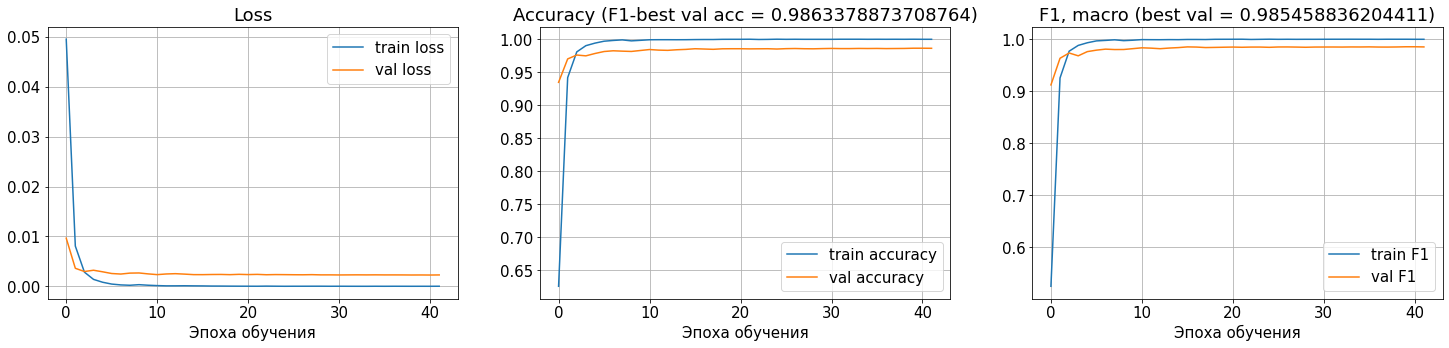

In [ ]:
plot_curves(learning_stats)

Ради общего интереса, посмотрим формально classification_report на оригинальном train-датасете:

In [ ]:
original_loader = torch.utils.data.DataLoader(
              DataframeDataset(
                  original_stats['image'],
                  original_stats['label'],  
                  data_transforms['val']    
              ), 
              batch_size=32,
              shuffle=False,
              num_workers=os.cpu_count()
)
best_model.eval()
original_preds = []
with torch.no_grad():
  for data in tqdm(original_loader, leave=False, desc=f"completed"):
      inputs, _ = data
      output = best_model(inputs.to(device))
      _, predicted = torch.max(output, 1)
      original_preds += predicted.tolist()


completed:   0%|          | 0/655 [00:00<?, ?it/s]

In [ ]:
original_stats['predicted'] = original_preds
original_labels2names = {v: k for k, v in original_labels.items()}
original_target_names = [original_labels2names[i] for i in range(len(original_labels))]
print(classification_report(original_stats['label'].tolist(), original_stats['predicted'].tolist(),target_names=original_target_names))

                          precision    recall  f1-score   support

           barney_gumble       0.99      0.98      0.99       106
  abraham_grampa_simpson       1.00      0.99      1.00       913
           marge_simpson       1.00      1.00      1.00      1291
             moe_szyslak       0.99      1.00      1.00      1452
            troy_mcclure       0.89      1.00      0.94         8
                fat_tony       1.00      1.00      1.00        27
            lisa_simpson       1.00      1.00      1.00      1354
      rainier_wolfcastle       0.98      1.00      0.99        45
           agnes_skinner       1.00      1.00      1.00        42
            nelson_muntz       0.99      0.99      0.99       358
               otto_mann       1.00      1.00      1.00        32
     milhouse_van_houten       1.00      1.00      1.00      1079
           martin_prince       1.00      0.99      0.99        71
          snake_jailbird       0.96      1.00      0.98        55
         

Подготовим данные для классификации:

In [ ]:
def submission_files_stats(dir):
  stats = pd.DataFrame(columns=['Id', 'Expected', 'image', 'sortnum'])
  for file in os.listdir(dir):
    path = dir + os.path.sep + file
    filename, extension = os.path.splitext(file)
    sortnum = int(filename[3:])
    stats.loc[len(stats)] = [
          file, 
          np.NaN,
          path,
          sortnum
      ]
  return stats.sort_values(by='sortnum')

In [ ]:
submissions_dir = 'testset/testset'
sub_stats = submission_files_stats(submissions_dir)
sub_stats

,Id,Expected,image,sortnum
197,img0.jpg,NaN,testset/testset/img0.jpg,0
175,img1.jpg,NaN,testset/testset/img1.jpg,1
658,img2.jpg,NaN,testset/testset/img2.jpg,2
123,img3.jpg,NaN,testset/testset/img3.jpg,3
974,img4.jpg,NaN,testset/testset/img4.jpg,4
...,...,...,...,...
716,img986.jpg,NaN,testset/testset/img986.jpg,986
76,img987.jpg,NaN,testset/testset/img987.jpg,987
879,img988.jpg,NaN,testset/testset/img988.jpg,988
475,img989.jpg,NaN,testset/testset/img989.jpg,989


In [ ]:
submission_loader = torch.utils.data.DataLoader(
              DataframeDataset(
                  sub_stats['image'],
                  sub_stats['sortnum'],  # метки не важны для предсказаний
                  data_transforms['val']    
              ), 
              batch_size=32,
              shuffle=False,
              num_workers=os.cpu_count()
)

Предсказываем и дополнительно сохраняем softmax-value для предсказанной категории:

In [ ]:
best_model.eval()
predicted_labels, predicted_probas = [], []
with torch.no_grad():
  for data in submission_loader:
      inputs, _ = data
      output = best_model(inputs.to(device))
      _, predicted = torch.max(output, 1)
      probas, _ = torch.max(nn.functional.softmax(output, dim=-1), 1)
      predicted_labels += predicted.tolist()
      predicted_probas += probas.tolist()

labels2names =  {v: k for k, v in labels.items()}
predicted_names = [labels2names[i] for i in predicted_labels]

In [ ]:
sub_stats['Expected'] = predicted_names
sub_stats['proba'] = predicted_probas
sub_stats

,Id,Expected,image,sortnum,proba
197,img0.jpg,nelson_muntz,testset/testset/img0.jpg,0,0.999999
175,img1.jpg,bart_simpson,testset/testset/img1.jpg,1,0.999992
658,img2.jpg,mayor_quimby,testset/testset/img2.jpg,2,0.999998
123,img3.jpg,nelson_muntz,testset/testset/img3.jpg,3,0.999878
974,img4.jpg,lisa_simpson,testset/testset/img4.jpg,4,0.999995
...,...,...,...,...,...
716,img986.jpg,sideshow_bob,testset/testset/img986.jpg,986,0.999992
76,img987.jpg,nelson_muntz,testset/testset/img987.jpg,987,0.999998
879,img988.jpg,ned_flanders,testset/testset/img988.jpg,988,0.999996
475,img989.jpg,charles_montgomery_burns,testset/testset/img989.jpg,989,0.999992


In [ ]:
sub_stats[['Id', 'Expected']].to_csv(
    'submission-' + str(time.time()) + ".csv",
    index=False
)

Выполненный submission на kaggle: https://www.kaggle.com/submissions/26080404/26080404.raw

Результат submission: 0.99468

Team: Georgy_Repin_128584

Доведение до 1.0 оставим тем, у кого есть на это время - ручное копание в датасете - это черезмерно time-consuming, и далеко не факт, что 1.0 достижим (а не имеет место банальная некорректность данных, в результате которой "взятие" 1.0 не более чем overfitting)

Посмотрим на распределение softmax-values для понимания, где проходит граница понятия "классификатор сомневается":


In [ ]:
sub_stats[['proba']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
proba,991.0,0.997701,0.028462,0.427681,0.999987,0.999995,0.999998,1.0


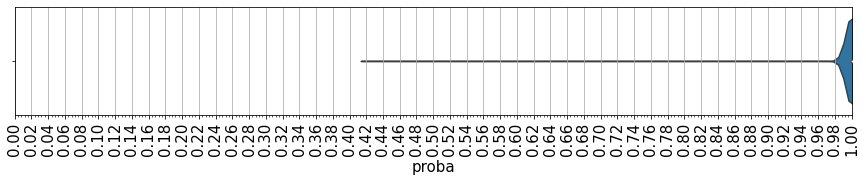

In [ ]:
import seaborn as sns
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = fig, ax = plt.subplots(figsize=(15,2)) 
ax.xaxis.grid(True)
ax.set_xlim(0, 1)
ax.xaxis.set_major_locator(MultipleLocator(0.02))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
plt.xticks(rotation=90)
o = sns.violinplot(ax=ax, x=sub_stats["proba"])

С неким приближением можно сказать, что с proba менее 0.99 модель начинает чувствовать себя "неуверенно" (хотя можно взять и три сигмы). Это некоторая условность, т.к. мы не знаем, какие в точности изображения модель распознала правильно, а какие - нет (а на поиск глазами просто жаль тратить время).

Ошибки классификации при данном подходе могут быть вызваны как часто встречающимся на изображениях с целевым классом неким "общим паттерном" (вероятно, есть отраслевая терминология?), не определяющим класс в нашем понимании, но который, будучи встречен (или не встречен) самостоятельно приведет к различным ошибкам классификации (обобщающий пример: "условный саксофон" отдельно от Лизы Симпсон при некорректном подборе датасета может привести к классификации всех изображений с саксофоном как "Лизы Симпсон" или всех картинок без саксофона но с Лизой как "что-то иное, а не Лиза Симпсом"), так и в принципе любым изображением, не относящимся (в нашем понимании) ни к одному из целевых классов.

JustForFun, посмотрим на эти изображения:

In [ ]:
problematic_submission = sub_stats.query('proba < 0.99') 
problematic_submission[['Id']].count()

Id    12
dtype: int64

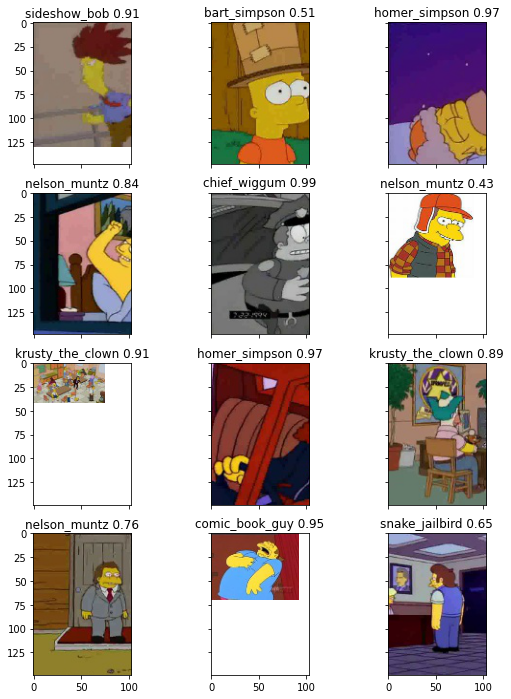

In [ ]:
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(nrows=4, ncols=3,figsize=(9, 12), 
                        sharey=True, sharex=True)
rips = problematic_submission.reset_index()
counter = 0
for fig_x in ax.flatten():
    im_val = Image.open(rips['image'].get(counter))
    img_label = "{} {:.2f}".format(
        rips['Expected'].get(counter),
        float(rips['proba'].get(counter))
    )
    fig_x.imshow(im_val) 
    fig_x.set_title(img_label)
    counter += 1

В позиции 2:1 "homer_simpson (0.97)" - прекрасный пример "непонятного нам паттерна", но "хорошо понятного нейросети паттерна". С другой стороны - огромные сомнения в 0:1 "bart_simpson (0.51)" - вероятнее всего в связи с отсутствием на изображении "зубчатой прически" как ключевого "паттерна", свойственного исключительно Барту. 
